
# Custom Data Fit

In this example, we use ``drdmannturb`` to fit a simple neural network model to real-world data without any preprocessing. This involves data that are observed in the real world, specifically near a North Sea wind turbine farm. The physical parameters are determined from those measurements. Additionally, the $\nu$ parameter is also learned.
is learned for the rational function for $\tau$ given by

\begin{align}\tau(\boldsymbol{k})=\frac{T|\boldsymbol{a}|^{\nu-\frac{2}{3}}}{\left(1+|\boldsymbol{a}|^2\right)^{\nu / 2}}, \quad \boldsymbol{a}=\boldsymbol{a}(\boldsymbol{k}).\end{align}


## Import packages

First, we import the packages needed for this example, obtain the current
working directory and dataset path, and choose to use CUDA if it is available.



In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn

from drdmannturb.enums import DataType
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

path = Path().resolve()

device = "cuda" if torch.cuda.is_available() else "cpu"

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")


spectra_file = (
    path / "./inputs/Spectra.dat"
    if path.name == "examples"
    else path / "../data/Spectra.dat"
)

## Setting Physical Parameters
Here, we define our characteristic scales $L, \Gamma, \sigma$, the
log-scale domain, and the reference height `zref` and velocity `Uref`.



In [2]:
domain = torch.logspace(-1, 3, 40)

L = 70  # length scale
GAMMA = 3.7  # time scale
SIGMA = 0.04  # energy spectrum scale

Uref = 21  # reference velocity
zref = 1  # reference height

## ``CalibrationProblem`` construction

We'll use a simple neural network consisting of two layers with $10$ neurons each,
connected by a ReLU activation function. The parameters determining the network
architecture can conveniently be set through the ``NNParameters`` dataclass.

Using the ``ProblemParameters`` dataclass, we indicate the eddy lifetime function
$\tau$ substitution, that we do not intend to learn the exponent $\nu$,
and that we would like to train for 10 epochs, or until the tolerance ``tol`` loss (0.001 by default),
whichever is reached first.

Having set our physical parameters above, we need only pass these to the
``PhysicalParameters`` dataclass just as is done below.

Lastly, using the ``LossParameters`` dataclass, we introduce a second-order
derivative penalty term with weight $\alpha_2 = 1$ and a
network parameter regularization term with weight
$\beta=10^{-5}$ to our MSE loss function.

Note that $\nu$ is learned here.



In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=2, hidden_layer_sizes=[10, 10], activations=[nn.ReLU(), nn.ReLU()]
    ),
    prob_params=ProblemParameters(
        data_type=DataType.CUSTOM, tol=1e-9, nepochs=5, learn_nu=True
    ),
    loss_params=LossParameters(alpha_pen2=1.0, beta_reg=1e-5),
    phys_params=PhysicalParameters(
        L=L,
        Gamma=GAMMA,
        sigma=SIGMA,
        domain=domain,
        Uref=Uref,
        zref=zref,
    ),
    logging_directory="runs/custom_data",
    device=device,
)

## Data from File
The data are provided in a CSV format with the first column determining the frequency domain, which must be non-dimensionalized by the reference velocity.
The different spectra are provided in the order ``uu, vv, ww, uw`` where the last is the u-w cospectra (the convention for 3D velocity vector components being u, v, w for x, y, z).
The ``k1_data_points`` key word argument is needed here to define the domain over which the spectra are defined.



In [4]:
CustomData = torch.tensor(np.genfromtxt(spectra_file, skip_header=1, delimiter=","))
f = CustomData[:, 0]
k1_data_pts = 2 * torch.pi * f / Uref
Data = OnePointSpectraDataGenerator(
    zref=zref,
    data_points=k1_data_pts,
    data_type=DataType.CUSTOM,
    spectra_file=spectra_file,
    k1_data_points=k1_data_pts.data.cpu().numpy(),
).Data

## Calibration
Now, we fit our model. ``CalibrationProblem.calibrate`` takes the tuple ``Data``
which we just constructed and performs a typical training loop. The resulting
fit for $\nu$ is close to $\nu \approx - 1/3$, which can be improved
with further training.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

pb.print_calibrated_params()

Initial loss: 5.221504564600699


  0%|                                                                          | 0/5 [00:00<?, ?it/s]

 20%|█████████████▏                                                    | 1/5 [00:06<00:25,  6.39s/it]

 40%|██████████████████████████▍                                       | 2/5 [00:11<00:16,  5.61s/it]

 60%|███████████████████████████████████████▌                          | 3/5 [00:16<00:10,  5.36s/it]

 80%|████████████████████████████████████████████████████▊             | 4/5 [00:21<00:05,  5.24s/it]

100%|██████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.25s/it]

100%|██████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.36s/it]

Spectra fitting concluded with final loss: 0.1848727953036264
Learned nu value: 0.0814942591733556
Optimal calibrated L     :  43.4085 
Optimal calibrated Gamma :   2.9920 
Optimal calibrated sigma :   0.0039 


## Plotting
``DRDMannTurb`` offers built-in plotting utilities and Tensorboard integration
which make visualizing results and various aspects of training performance
very simple.

The following will plot our fit. As can be seen, the spectra is fairly noisy,
which suggests that a better fit may be obtained from pre-processing the data, which
we will explore in the next example.



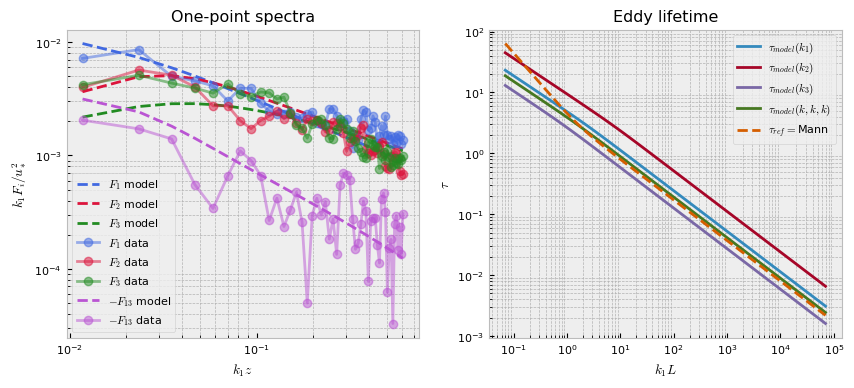

In [6]:
pb.plot()

This plots out the loss function terms as specified, each multiplied by the
respective coefficient hyperparameter. The training logs can be accessed from the logging directory
with Tensorboard utilities, but we also provide a simple internal utility for a single
training log plot.



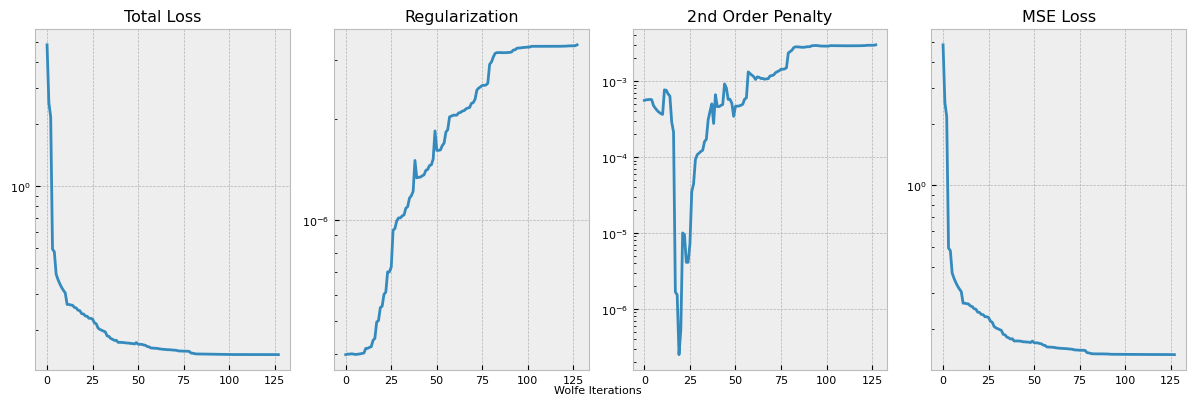

In [7]:
pb.plot_losses(run_number=0)